In [1]:
import os
os.getcwd()

'/home/khalid/Desktop/BDP2'

# $\color{red}{MARKED}$
# Data Wrangling with Spark
Welcome to assignment-2-part-2 for the BDA course where you will use spark together with pandas to 
perfom common data processing tasks which are often part of a larger data science project. Please use the ```simulated_cdrs``` dataset.

By the end of the asssignment, you will have accomplished the following:
- how to setup a data science project 
- appreciate effect of your design choices on effiency when dealing with large datasets
- appreciate that how you sample data will vary alot depending on the nature of the data
- ability to manipulate spark dataframes, use spark user defined functions
- ability to switch betweeen spark dataframes which are distributed and pandass dataframes (which arent) as needed


For this assignment, please use the [pyspark API documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/dataframe.html) to get details about specific functions when you use them.

## Python setup

In [1]:
# import other packages you need for this assignment
from datetime import datetime
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import seaborn as sn
import matplotlib.pyplot as plt
import shutil

## 1-Sampling data
When working with large datasets, you often need to sample the data so that you can 
build and test your awesome algorithms on a smaller dataset without having to wait 10 minutes or hours depending on what you working with. However, sampling is not as straightfoward as you think, when the data is large and the sampling process complicated, you can even get stuck in the sampling stage. In this exercise, you will explore three strategies to achieve the same goal of sampling data. You will compare the efficiency of the three approaches.

### 1-First sampling approach: isin()
Given a list of users (their ```user_id```) that we have sampled from somewhere (in this case a pandas dataframe),
we can use the function ```isin()``` on the spark dataframe (i.e the large input dataframe) and apply ```isin()``` 
to keep only the users in the list.
### 2-Second sampling approach: join
Once we have a list of user_id's whose data we need, we can convert that into a spark dataframe, 
then join with the input large dataframe. This will give us the required data, assuming we use thee correct join. However, joins can be very slow if you have a lot of data because its a shuffle operation.
### 3-Third sampling approach: broadcast join
When joining, if you have one smaller dataset and its small enough to fit into the memory of each worker, we can turn ShuffleHashJoin or SortMergeJoin into a BroadcastHashJoin. In broadcast join, the smaller dataFrame will be broadcasted to all worker nodes. Whats broadcasting?
> Broadcast variables are read-only shared variables that are cached and available on all nodes in a cluster in-order to access or use by the tasks. Instead of sending this data along with every task, PySpark distributes broadcast variables to the workers using efficient broadcast algorithms to reduce communication costs.

When joining, we can use the ```BROADCAST hint``` which  tells Spark to broadcast the smaller DataFrame when joining them with the bigger one. See how to use hints [here](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.hint.html).

In [3]:
path="/home/khalid/Desktop/Big_Data/Big_Data/simulated_cdrs/HW2018062913066551.dat.csv"
spark =SparkSession.builder.master("local[*]").appName('khalid').getOrCreate()
df= spark.read.csv(
    path = path,
    header = True,
   )
p= df.groupBy('user_id').agg(count_distinct('cdr type')).toPandas()
pdf = p[p['count(cdr type)']== 2]
pdf2 = pdf.sample(5)
list(pdf2['user_id'])

['7653770530001754046',
 '8590010677447961327',
 '1926154774479987037',
 '7353925686673190405',
 '1812788598358233510']

In [2]:
def sample_users(sdf, min_events, num_users, method, output_csv):
    """
    Sample users with minimum number of events
    Arguments:
    url -- spark dataframe tot work on
    num_users -- number of users to sample
    min_events -- minimum number of events
    method -- eitheer join based meethod or isin() query
    output_csv -- full path to ssave data for sampled users
    """
    
    # Use groupBy on appropriate column to get number of events
    # per user (~ 1 line) and conveert the resulting dataframe to 
    # a pandas dataframe
    pdf =sdf.groupBy('user_id').agg(count_distinct('cdr type')).toPandas()
    
    # Keep users with min_events as required
    # Also, keep only num_users (~2 lines)
    pdf = pdf[pdf['count(cdr type)'] == min_events]
    pdf2 = pdf.sample(num_users)
    
    # =================================min_events==
    # RETRIEVE DATA FOR THE SAMPLED USERS
    # ===================================
    # using the isin() method as follows:
    # 1. Get a list of sampled users from pdf2 above
    # 2. Use isin() method to sample data
    # 3. Save data to CSV file.
    # replace pass with your code (~3 lines)
    if method == "isin":
        sampled_list = list(pdf2['user_id'])
        samp_dat = sdf.filter(sdf.user_id.isin(sampled_list))
        samp_dat.write.csv(output_csv)
    elif method == "join-broadcast":
        # In order to use join to select the data, do the following:
        # 1. dataconvert the pandas dataframe to spark
        # 2. join the two dataframes making sure you select the correct join type
        # this is broadcast join, so use hint as decsribed in docs
        # 3. Save the data
        # replace path with your code (~3-4 lines)
        # If you have issues with conversion from pandas to spark, use a scheme
        spark_df = spark.createDataFrame(pdf2)
        joinB_df = sdf.join(spark_df.hint('broadcast'),'user_id','leftsemi' )
        joinB_df.write.csv(output_csv)
    else:
        # this is regular join without broadcast
        spark_df = spark.createDataFrame(pdf2)
        joinR_df = sdf.join(spark_df,sdf.user_id==spark_df.user_id, 'leftsemi')
        joinR_df.write.csv(output_csv)

In [5]:
# sample_users(sdf=df, min_events=2, num_users=5, method="is", output_csv="reg.csv")

In [6]:
# output_csv = Path(out_pth).joinpath('hello.txt')
# output_csv

In [3]:
def compare_running_times(input_csv_file, output_dir):
    """
    Run the sample_users funcition above using three
    different approaches and report the one with fasest
    run time
    Arguments:
    input_csv_file -- full path to the input CSV file
    output_dir --  directory (as a Path object) to save the sampled files
    """
    
    # create sparksession object and load the dataframe
    spark =SparkSession.builder.master("local[*]").appName('khalid').getOrCreate()
    df = spark.read.csv(input_csv_file, header=True)
    
    methods = ['isin', "join-broadcast", 'join']
    
    # dictionary to hold time taken results
    time_taken ={}
    
    # Loop through the methods and do the following:
    # 1. Create 
    for m in methods:
        # Use joinpath() method on output_dir to create outcsv for this method
        # the CSV file should have name: sample_method.csv
        output_csv = output_dir.joinpath(m+'sample_method.csv')
        # use datetime.now() method to records start time
        start = datetime.now()
        # Call the sample_users() function (~1 line)
        sample_users(df, 1, 100, m, str(output_csv))
        # Record finish time 
        end =datetime.now()
        
        # Calculate duration in minutes
        # Use total_seconds() function on the time difference
        duration = (end - start).total_seconds()
        
        # Add the duration to the results dictionary
        # with method as key (~1 line)
        time_taken[m]= duration/60
    
    # Get the best and worst running times
    # Please use the dictionary to get the maximum and minimun
    # values as required
    best =sorted(time_taken, key=lambda i: i[1])[0]
    worst =sorted(time_taken, key=lambda i: i[1])[-1]
    
    print('Best approach is {} which took {} minutes'.format(best, int(time_taken[best])))
    print('Worst approach is {} which took {} minutes'.format(worst, int(time_taken[worst])))
    
    spark.stop()

In [8]:
# out_pth = "/home/khalid/Desktop/BDP2/Out_put"
# path ="/home/khalid/Desktop/Big_Data/Big_Data/simulated_cdrs/HW2018062913026547.dat.csv"
# compare_running_times(path, out_pth)

In [9]:
time_taken ={'isin':3, "join-broadcast":2, 'join':5}
best =sorted(time_taken, key=lambda i: i[1])[0]
worst =sorted(time_taken, key=lambda i: i[1])[-1]
type(best)
print('Best approach is {} which took {} minutes'.format(best, int(time_taken[best])))
print('Worst approach is {} which took {} minutes'.format(worst, int(time_taken[worst])))

Best approach is join-broadcast which took 2 minutes
Worst approach is isin which took 3 minutes


## 2-Data exploration using spark
In this part of the asssignment, you will get to perfom basic operations on a spark dataframe such 
as adding new columns, droping columns and more. Once you have summarized the data and its small enough, 
you can convert it to a pandas dataframe and do some analysis with pandas. Please complete the functiton below by 
following the steps below.

### 1-Preprocess the data
In this step, you will add new columns, drop columns and rename some columns. You will use the ```user defined function (udf)``` to add a date and datetime column to be used later in the analysis. This is because the original ```cdr_datetime``` is a sstring and is not time aware in Python. For this, please read on how to [define and use udf in spark](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.udf.html#pyspark.sql.functions.udf)

### 2-Get number of days
One important thing we would like to know is how many days of data do we have. 
You will use the date column created above to get the number of days. During this process, 
note that you will be working with spark's ```Row``` data type.

### 3-Get a distribution of calls by hour
Also important to know is how many calls are made on each hour. To this end, 
you will use aggregate function to generate this and out the results as a heatmap for easier visualization.
### 4-User attributes
Finally, you will get one user attribute which is number of calls per day. Once you get this, you report the mean and median number of calls per day for users. 

In [10]:
df.show(5)

+------------+--------------+-------------+-------------------+-------------------+
|    cdr type|  cdr datetime|call duration|last calling cellid|            user_id|
+------------+--------------+-------------+-------------------+-------------------+
| MtSMSRecord|20180629130501|         null|               null|3384066821637594455|
| MtSMSRecord|20180629130501|         null|               null|7566424924061690786|
|MoCallRecord|20180629130443|         null|            14232.0|8679125349265681507|
|MtCallRecord|20180629130443|         null|               null|8679125349265681507|
|MoCallRecord|20180629130458|         null|            20357.0|4700647867365546975|
+------------+--------------+-------------+-------------------+-------------------+
only showing top 5 rows



In [11]:
path="/home/khalid/Desktop/Big_Data/Big_Data/simulated_cdrs/HW2018062913066551.dat.csv"
df= spark.read.csv(
    path = path,
    header = True,
   )
df.show(5)

+------------+--------------+-------------+-------------------+-------------------+
|    cdr type|  cdr datetime|call duration|last calling cellid|            user_id|
+------------+--------------+-------------+-------------------+-------------------+
| MtSMSRecord|20180629130501|         null|               null|3384066821637594455|
| MtSMSRecord|20180629130501|         null|               null|7566424924061690786|
|MoCallRecord|20180629130443|         null|            14232.0|8679125349265681507|
|MtCallRecord|20180629130443|         null|               null|8679125349265681507|
|MoCallRecord|20180629130458|         null|            20357.0|4700647867365546975|
+------------+--------------+-------------+-------------------+-------------------+
only showing top 5 rows



In [12]:
# from functools import reduce
# cols= df.columns
# print(cols)
# newcol= ["cdr_datetime","cell_id","call_duration"]
# # df1= reduce(lambda n,i:n.withColumnRenamed(i,i.replace(" ","_").replace("last calling cellid", "call_duration")),cols,df)
# df1= reduce(lambda n,i:n.withColumnRenamed(cols[i],newcol[i-1]),range(1,len(newcol)+1),df)
df1= df.select(
    df.columns
).withColumnRenamed( 
    "cdr datetime","cdr_datetime"
).withColumnRenamed(
    "last calling cellid","cell_id"
).withColumnRenamed("call duration","call_duration")
df1.show(5)


+------------+--------------+-------------+-------+-------------------+
|    cdr type|  cdr_datetime|call_duration|cell_id|            user_id|
+------------+--------------+-------------+-------+-------------------+
| MtSMSRecord|20180629130501|         null|   null|3384066821637594455|
| MtSMSRecord|20180629130501|         null|   null|7566424924061690786|
|MoCallRecord|20180629130443|         null|14232.0|8679125349265681507|
|MtCallRecord|20180629130443|         null|   null|8679125349265681507|
|MoCallRecord|20180629130458|         null|20357.0|4700647867365546975|
+------------+--------------+-------------+-------+-------------------+
only showing top 5 rows



In [13]:
df11=df1.drop("cdr type")
df11.show()

+--------------+-------------+-------+-------------------+
|  cdr_datetime|call_duration|cell_id|            user_id|
+--------------+-------------+-------+-------------------+
|20180629130501|         null|   null|3384066821637594455|
|20180629130501|         null|   null|7566424924061690786|
|20180629130443|         null|14232.0|8679125349265681507|
|20180629130443|         null|   null|8679125349265681507|
|20180629130458|         null|20357.0|4700647867365546975|
|20180629130458|         null|   null|4700647867365546975|
|20180629130500|         null|12003.0|7624626017140993702|
|20180629130500|         null|   null|7624626017140993702|
|20180629130408|         null|20353.0|8363160904912796315|
|20180629130501|         null|   null|7566424924061690786|
|20180629130501|         null|   null|7566424924061690786|
|20180629130443|         null|34062.0|8173164567983722784|
|20180629130443|         null|   null|8173164567983722784|
|20180629130449|         null|20333.0|517264874576233215

In [14]:
date_format = '%Y%m%d%H%M%S'
add_datetime = udf(lambda colname:datetime.strptime(colname, date_format),TimestampType())
df4 =df11.withColumn("datetime",(add_datetime(df11.cdr_datetime)))
add_date = udf(lambda colname:datetime.strptime(colname, date_format),DateType())
d2=df4.withColumn("date",(add_date(df4.cdr_datetime)))
d2.show()

+--------------+-------------+-------+-------------------+-------------------+----------+
|  cdr_datetime|call_duration|cell_id|            user_id|           datetime|      date|
+--------------+-------------+-------+-------------------+-------------------+----------+
|20180629130501|         null|   null|3384066821637594455|2018-06-29 13:05:01|2018-06-29|
|20180629130501|         null|   null|7566424924061690786|2018-06-29 13:05:01|2018-06-29|
|20180629130443|         null|14232.0|8679125349265681507|2018-06-29 13:04:43|2018-06-29|
|20180629130443|         null|   null|8679125349265681507|2018-06-29 13:04:43|2018-06-29|
|20180629130458|         null|20357.0|4700647867365546975|2018-06-29 13:04:58|2018-06-29|
|20180629130458|         null|   null|4700647867365546975|2018-06-29 13:04:58|2018-06-29|
|20180629130500|         null|12003.0|7624626017140993702|2018-06-29 13:05:00|2018-06-29|
|20180629130500|         null|   null|7624626017140993702|2018-06-29 13:05:00|2018-06-29|
|201806291

In [15]:
pn= d2.select("date").distinct().toPandas()
pn

,date
0,2018-06-29


In [16]:
pn.sort_values(by='date', ascending=False)
print (pn.index.min()-pn.index.max())

0


In [4]:
def explore_data_with_spark(sdf=None, output_plot_file=None, output_heatmap=None):
    """
    For quick examination of user activity, lets generate
    user call count and do a simple plot.
    """
    # ======================================
    # DO QUICK PRE-PROCESSING
    # ======================================
    # 1.rename the following columns:
    # cdr datetime =>cdr_datetime", "last calling cellid"=>"cell_id")
    # "call duration"=>"call_duration"

    df2 =  sdf.select(sdf.columns).withColumnRenamed(
        "cdr datetime","cdr_datetime").withColumnRenamed(
        "last calling cellid","cell_id").withColumnRenamed(
        "call duration","call_duration")
    
    # drop cdr type column
    df3 = df2.drop("cdr type")
    
    # 2. add datetime and date by converting from string cdr_datetime
    # Use Spark UDF to add date and datetime
    date_format = '%Y%m%d%H%M%S'
    
    # define udf to convert from string to Python datetime
    # To convert from string to datetime, use function  datetime.strptime()
    # Use spark TimestampType() data type as the output
    add_datetime = udf(lambda colname:datetime.strptime(colname, date_format),TimestampType())
    
    # For date, same instructions ass above but use spark DateType()
    add_date = udf(lambda colname:datetime.strptime(colname, date_format),DateType())

    # Now add new columns for datetime and 'date' by calling 
    # the udfs above
    df4 =df3.withColumn("datetime",(add_datetime(df3.cdr_datetime)))
    df5 =df4.withColumn("date",(add_date(df4.cdr_datetime)))
    
    # ======================================
    # NUMBER OF DAYS IN THE DATA
    # ======================================
    # Get how many days are in the data by doing the following
    # 1. Get unique dates by using distinct() on the spark dataframe
    # 2. You can either use collect() on the result or covert to pandas dataframe
    # 3. Use sorting to get the first (earliest) and last date 
    # These instructions assume you are using collect() which wil give us
    # spark Row objects. Otherwise, if you end up using pandas, please 
    # write your 
    dates_rows =  df5.select("date").distinct().toPandas()
    # use sorted() and list comprehension to sort the list of dates
    sorted_dates =dates_rows.sort_values(by='date', ascending=True)
    diff = sorted_dates.index.max()-sorted_dates.index.min()
    # You can use days() function on the diff object
    num_days = diff

    # ======================================
    # AGGREGATE TO GET CALL COUNT BY HOUR
    # ======================================
    # define  udf to add hour column using atdfWkDay.drop(labels=['wkday'], axis=1, inplace=True)tribute hour
    # on a datetime
    add_hr = udf(lambda colname:colname.hour)
    
    # define udf to add weekday as a number 
    # using python function weekday() on a date object
    add_wkday =udf(lambda colname:colname.weekday())
 
    # create dict with nums (starting from 0) as keys and 
    # days as values
    day_dict ={'0':'Sunday','1':'Monday','2':'Tuesday','3':'Wednesday','4':'Thursday','5':'Friday','6':'Saturday'}
    # add hour column to the spark dataframe
    dfHr = df5.withColumn("hour",add_hr(df5.datetime))
    
    # add wkday column
    dfHr2 = dfHr.withColumn("wkday",(add_wkday(dfHr.date)))
    
    # group by to get week day and hour to get
    # total events by day and hour and convert result
    # to pandas dataframe
    dfWkDay = dfHr2.groupBy("wkday","hour").count().toPandas()
    
    # use pandas map() function on column wkday
    # to get the wkday name and add that as a column
    dfWkDay['wkday_name'] =dfWkDay['wkday'].map(day_dict)
    
    dfWkDay.drop(labels=['wkday'], axis=1, inplace=True)
    dfWkDayPivot = dfWkDay.pivot(index='wkday_name', columns='hour', values='count')
    
    # Create a heatmap with sns.heatmap() and the dfWkDayPivot dataframe
    ax =sn.heatmap(data=dfWkDayPivot)
    
    # Save output to file (~ 1 line)
    plt.savefig(output_heatmap)
    
    # ==============================================
    # GET USER ATTRIBUTES: CALLS PER DAY
    # ============================================
    # group user and count number of events
    # convert resulting spark dataframe to pandasFalse
    dfGroup =df5.groupBy("user_id").count().toPandas()

    # create a distribution plot of user call count using
    # seaborn
    axl = sns.displot(dfGroup['count'])
    # save plot as png file(~ 1 line)
    plt.savefig(output_plot_file)
    
    # report average number calls per day for each user
    # by grouping by user_id and date
    # and convert resullt to pandas dataframe
    dfGroupDay =df5.groupBy("user_id","date").count().toPandas()
    
    
    # get mean and median days based on
    # grouped dataframe above
    mean =dfGroupDay.mean()
    median =dfGroupDay.median() 

    return mean, median, num_days

In [5]:
def check_sampled_csv(output_from_sample_func, num_users, min_events):
    """
    Check if the output from sample function has correct number of users
    """
    
    # ===================================================
    #       MARKING COMMENT 
    # If the two tests are passed, student gets 6 points
    # If not, subtract accordingly
    # ===================================================
    
    df = pd.read_csv(output_from_sample_func)
    df_users = df.groupby('user_id').count().reset_index()[['user_id', 'count']]
    
    try:
        assert num_users == df_users.shape[0]
        print('Passed first test, give 3 points')
    except:
        print('Number of users doesnt match with expected from sample, subtract 3 points')
    
    try:
        min_events_from_df = df_users['count'].min()
        assert min_events_from_df >= min_events
        print('Passed second test, give 3 points')
    except:
        print('Minimum number of events doesnt match, subtract 3 points')

In [6]:
#outd = Path("../DATA/simulated_cdrs_sample/")
outd = Path("/home/joseph/Dropbox/Tutors2022-2023/AIMS_Assignment2022-2023/Review Phase/BDP/Assignment2/aaMARKING_BDP/simulated_cdrs_sample/")

cnt = 1
#for file in Path("../DATA/simulated_cdrs/").iterdir():
for file in Path("/home/joseph/Dropbox/Tutors2022-2023/AIMS_Assignment2022-2023/Review Phase/BDP/Assignment2/aaMARKING_BDP/simulated_cdrs/").iterdir():
    if file.suffix == ".csv":
        shutil.copy(file, outd.joinpath(file.parts[-1]))
        cnt += 1
        if cnt == 5000:
            break

In [7]:
# Please change paths to the one where you put the simulated_cdrs_sample folder 
# Also, create the out_cdr_analysis folder
# input_cdrs = "../DATA/simulated_cdrs_sample/"
# output_dir = Path( "../DATA/out_cdr_analysis/")
input_cdrs = "/home/joseph/Dropbox/Tutors2022-2023/AIMS_Assignment2022-2023/Review Phase/BDP/Assignment2/aaMARKING_BDP/simulated_cdrs_sample/"
output_dir = Path( "/home/joseph/Dropbox/Tutors2022-2023/AIMS_Assignment2022-2023/Review Phase/BDP/Assignment2/aaMARKING_BDP/out_cdr_analysis/")


## Parameters for testing
NUM_USERS = 3000
MIN_EVENTS = 100

In [8]:
# create spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Hello Spark") \
    .getOrCreate()

# please use the sample users from previous function to reduce computation time
# you can start experimenting witth very few user data
# load a spark dataframe
df = spark.read.csv(input_cdrs, header=True).repartition(10)

In [9]:
# Run  sample_users() with method = join-broadcast
# Give 3 points if it runs successfully and 0 if it doesnt
start = datetime.now()
# you need to be deleting the output folder/file every time you re-run this 
# as spark doesnt replace directories
output_csv = output_dir.joinpath('sample_broadcast_join.csv')
sample_users(sdf=df, min_events=MIN_EVENTS, num_users=NUM_USERS, method="join-broadcast", 
             output_csv=str(output_csv))
end = datetime.now()
duration = (end - start).total_seconds()/60
print('Time taken for join-broadcast: {} minutes'.format(int(duration)))

ValueError: a must be greater than 0 unless no samples are taken

In [19]:
# import seaborn as sn
# import matplotlib.pyplot as plt
# explore_data_with_spark(sdf=df, output_plot_file=out_distplot, output_heatmap=out_heatmap)

In [ ]:
# d2.show(5)

In [20]:
# add_hr = udf(lambda colname:colname.hour)
# dh= d2.withColumn("hour",add_hr(d2.datetime))
# add_wkday =udf(lambda colname:colname.weekday())
# dw=dh.withColumn("week",(add_wkday(dh.date)))
# dw.show()

+--------------+-------------+-------+-------------------+-------------------+----------+----+----+
|  cdr_datetime|call_duration|cell_id|            user_id|           datetime|      date|hour|week|
+--------------+-------------+-------+-------------------+-------------------+----------+----+----+
|20180629130501|         null|   null|3384066821637594455|2018-06-29 13:05:01|2018-06-29|  13|   4|
|20180629130501|         null|   null|7566424924061690786|2018-06-29 13:05:01|2018-06-29|  13|   4|
|20180629130443|         null|14232.0|8679125349265681507|2018-06-29 13:04:43|2018-06-29|  13|   4|
|20180629130443|         null|   null|8679125349265681507|2018-06-29 13:04:43|2018-06-29|  13|   4|
|20180629130458|         null|20357.0|4700647867365546975|2018-06-29 13:04:58|2018-06-29|  13|   4|
|20180629130458|         null|   null|4700647867365546975|2018-06-29 13:04:58|2018-06-29|  13|   4|
|20180629130500|         null|12003.0|7624626017140993702|2018-06-29 13:05:00|2018-06-29|  13|   4|


In [21]:
# dfWkD = dw.groupBy("week","hour").count().toPandas()
# print(dfWkD)
# day_dict ={'0':'Sunday','1':'Monday','2':'Tuesday','3':'Wednesday','4':'Thursday','5':'Friday','6':'Saturday'}


  week hour  count
0    4   12    107
1    4   13  15351


In [22]:
# dfWkD["day_name"] = dfWkD['week'].map(day_dict)
# print(dfWkD)

  week hour  count  day_name
0    4   12    107  Thursday
1    4   13  15351  Thursday


## 3-Put it all together.
From the ```sample_users()``` function, you should have sample data for subset of users 
which you can use with the ```explore_data_with_spark()``` function. Note that you can make the number of users very small at the beginning ass you test the function.

Best approach is join-broadcast which took 0 minutes
Worst approach is isin which took 0 minutes


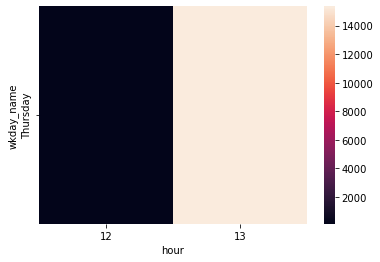

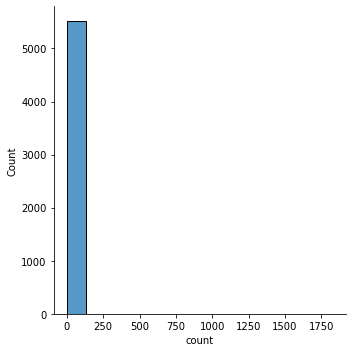

In [29]:
# ==============================
# SAMPLING USER DATA
# ==============================
# setup input file and output directory
path="/home/khalid/Desktop/Big_Data/Big_Data/simulated_cdrs/HW2018062913066551.dat.csv"
input_cdrs = "/home/khalid/Desktop/Big_Data/Big_Data/simulated_cdr/"

# Convert the output dir str into a Path object
# using Path() function
outdir = Path("/home/khalid/Desktop/BDP2/Out_put")

# Call the compare_running_times() function (~ 1 line)
compare_running_times(input_csv_file=path, output_dir=outdir)

# ==============================
# DATA EXPLORATION
# ==============================
# create spark session
spark =SparkSession.builder.master("local[*]").appName('khalid').getOrCreate()

# please use the sample users from previous function to reduce computation time
# you can start experimenting witth very few user data
# load a spark dataframe
df= spark.read.csv(path = path,header = True)

# provide full paths to save distplot and heatmap
out_heatmap = '/home/khalid/Desktop/BDP2/Out_put/heatmap.png'
out_distplot ='/home/khalid/Desktop/BDP2/Out_put/distplot.png'

# Call the explore_data_with_spark() function
mean, median, num_days =explore_data_with_spark(sdf=df, output_plot_file=out_distplot, output_heatmap=out_heatmap)

### observation 
The function  ```compare_running_times(input_csv_file output_dir=)``` runs ```once``` on a ```csv``` file and it will create 3-other csvs. it then return an error whem it is aplied on the same `csv`  

### Question based on ```sample_users() function```
1. Why are we sampling the data the way we are doing. Why can't we just randomly sample 
from the input dataframe ```sdf``` without worrying about the user id's and grouping users?
2. What other spark function(s) (on a dataframe) could we have explored to achieve the same goal?

## Congratulations on completing this part of assignment!
Here some notes on how the assingment will be marked. Full marks will be 
achieved based on two main criteria:
- Code is able to run and saves all the outputs as required
- The saved outputs are as expected: heatmap and distribution plot
- The returned values for ```mean, median, num_days``` are accurate

Also, please answer the question above in the same below the question. It will be marked.